In [2]:
def transform_metrics_based_on_5m(df, skew_threshold=1.0):
    """
    Transforms skewed metrics based on their 5-minute resolution version.
    Applies the same transformation to all resolutions of that metric.
    Removes the original columns after transformation.

    Naming convention:
    - Input column format: {metric}_{resolution}
    - Output column format: {metric}_{transform}_{resolution} (e.g., I30_log_60m)

    Parameters:
        df (pd.DataFrame): Input DataFrame with metrics at multiple resolutions.
        skew_threshold (float): Absolute skew value above which transformation is applied.

    Returns:
        pd.DataFrame: A new DataFrame with transformed columns added and raw versions removed.
    """
    transformed_cols = []  # list of DataFrames to concat
    kept_cols = []         # original cols that are not transformed

    all_cols = df.columns
    metric_resolution_pairs = [col.rsplit('_', 1) for col in all_cols]
    metric_to_resolutions = {}

    for metric, res in metric_resolution_pairs:
        metric_to_resolutions.setdefault(metric, []).append(res)

    for metric, resolutions in metric_to_resolutions.items():
        ref_col = f"{metric}_5m"
        if ref_col not in df.columns:
            continue

        ref_skew = skew(df[ref_col].dropna())
        if abs(ref_skew) <= skew_threshold:
            # Keep all original columns for this metric
            kept_cols.extend([f"{metric}_{res}" for res in resolutions if f"{metric}_{res}" in df.columns])
            continue

        # Apply transformation
        use_log = (df[ref_col] > 0).all()
        for res in resolutions:
            original_col = f"{metric}_{res}"
            if original_col not in df.columns:
                continue

            col_data = df[original_col].values.reshape(-1, 1)
            if use_log:
                transformed = np.log1p(col_data).flatten()
                new_col = f"{metric}_log_{res}"
            else:
                pt = PowerTransformer(method='yeo-johnson', standardize=False)
                transformed = pt.fit_transform(col_data).flatten()
                new_col = f"{metric}_yj_{res}"

            transformed_cols.append(pd.DataFrame({new_col: transformed}, index=df.index))

    # Concatenate final DataFrame from untransformed columns and all new transformed columns
    final_df = pd.concat([df[kept_cols]] + transformed_cols, axis=1)

    return final_df


# --- Helper function to split column name into metric and resolution --- #
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found

def select_best_transformed_version(df):
    selected_cols = []

    # Get all base column names (before _log or _yj)
    base_cols = set(col.replace('_log', '').replace('_yj', '') for col in df.columns)

    for base in base_cols:
        log_col = base + '_log'
        yj_col = base + '_yj'

        if log_col in df.columns:
            selected_cols.append(log_col)
        elif yj_col in df.columns:
            selected_cols.append(yj_col)
        elif base in df.columns:
            selected_cols.append(base)
        # else: skip — no usable version of this metric

    return df[selected_cols].copy()

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from scipy.interpolate import interp1d
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp
import pickle
import datetime 
import warnings
import sys
from scipy.stats import skew
import re
import matplotlib.colors as mcolors
import seaborn as sns

from datetime import timedelta
import skill_metrics as sm
warnings.simplefilter(action='ignore', category=FutureWarning)

# from ClassFunctions_OtherRes import precip_time_series, rainfall_analysis
sys.path.insert(0, '../')
from PlottingFunctions import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [104]:
all_events_df_5mins = pd.read_csv('../../all_events_df_5mins.csv')
all_events_df_10mins = pd.read_csv('../../all_events_df_10mins.csv')
all_events_df_30mins = pd.read_csv('../../all_events_df_30mins.csv')
all_events_df_60mins = pd.read_csv('../../all_events_df_60mins.csv')

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (141) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Remove rows with unrealistically high precip

In [105]:
bad_indices = all_events_df_5mins.sort_values(by="total_precip", ascending=False)[:15].index

# Drop rows at these indices from all dataframes
all_events_df_5mins = all_events_df_5mins.drop(index=bad_indices)
all_events_df_10mins = all_events_df_10mins.drop(index=bad_indices)
all_events_df_30mins = all_events_df_30mins.drop(index=bad_indices)
all_events_df_60mins = all_events_df_60mins.drop(index=bad_indices)

for df in [all_events_df_5mins, all_events_df_10mins, all_events_df_30mins, all_events_df_60mins]:
    df.reset_index(drop=True, inplace=True)
    
print(len(all_events_df_5mins), len(all_events_df_10mins), len(all_events_df_30mins), len(all_events_df_60mins))

### Specify just raw columns to keep
raw_cols = []
for col in all_events_df_5mins.columns:
    if not col.endswith('_DMC_10') and not col.endswith('dblnorm'):
        raw_cols.append(col)

### Also remove 'frac_q1', 'frac_q2', 'frac_q3', 'frac_q4'
# Because these bring lots of nans (with current calculation method)

cols_to_del = ['frac_q1', 'frac_q2', 'frac_q3', 'frac_q4']
more_cols_to_del = ['gauge_num',  'start_time', 'end_time', 'duration' ,'total_precip',  'event_num', 'peak_mean_ratio_scaled',
                   'heaviest_half']

raw_cols = [x for x in raw_cols if x not in cols_to_del]  
raw_cols = [x for x in raw_cols if x not in more_cols_to_del]    

### Do the actual deleting
all_events_df_5mins_raw = all_events_df_5mins[raw_cols]
all_events_df_10mins_raw = all_events_df_10mins[raw_cols]
all_events_df_30mins_raw = all_events_df_30mins[raw_cols]
all_events_df_60mins_raw = all_events_df_60mins[raw_cols]

print(len(all_events_df_5mins_raw), len(all_events_df_10mins_raw), len(all_events_df_30mins_raw), len(all_events_df_60mins_raw))

bad_indices_all = []
for all_events_df in [all_events_df_5mins_raw, all_events_df_10mins_raw, all_events_df_30mins_raw, all_events_df_60mins_raw]:
    columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
    print("Columns with at least one NaN value:")
    print(columns_with_nan)
    # #Find indices of rows with any NaNs in the 60-minute data
    bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
    bad_indices_lst = bad_indices.tolist()
    print(len(bad_indices_lst))
    if len(bad_indices) >0:
        bad_indices_all.extend(bad_indices_lst)
    
# Drop rows at these indices from all dataframes
all_events_df_5mins_raw = all_events_df_5mins_raw.drop(index=bad_indices_all)
all_events_df_10mins_raw = all_events_df_10mins_raw.drop(index=bad_indices_all)
all_events_df_30mins_raw = all_events_df_30mins_raw.drop(index=bad_indices_all)
all_events_df_60mins_raw = all_events_df_60mins_raw.drop(index=bad_indices_all)   

print(len(all_events_df_5mins_raw), len(all_events_df_10mins_raw), len(all_events_df_30mins_raw), len(all_events_df_60mins_raw))
        

364464 364464 364464 364464
364464 364464 364464 364464
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
[]
0
Columns with at least one NaN value:
['asymm_d', 'Event Loading', 'lorentz_asymetry', 'Mean Intensity HIZ']
6
364458 364458 364458 364458


### Join all into one dataframe

In [106]:
metric_columns =all_events_df_5mins_raw.columns

all_events_df_5mins_raw = all_events_df_5mins_raw.add_suffix('_5m')
all_events_df_10mins_raw = all_events_df_10mins_raw.add_suffix('_10m')
all_events_df_30mins_raw = all_events_df_30mins_raw.add_suffix('_30m')
all_events_df_60mins_raw = all_events_df_60mins_raw.add_suffix('_60m')

all_events_all_res = pd.concat([all_events_df_5mins_raw, all_events_df_10mins_raw,
                               all_events_df_30mins_raw, all_events_df_60mins_raw], axis=1)

## Check skewness of variables

In [ ]:
# metric_columns = all_events_df.columns
# metric_columns = metric_columns.drop(['gauge_num', "start_time", "end_time"])
# all_events_df = all_events_df[metric_columns]

## Scale variables

In [108]:
transformed_all_events_df = transform_metrics_based_on_5m(all_events_all_res)
transformed_all_events_df2 = select_best_transformed_version(transformed_all_events_df)

In [109]:
metrics_to_scale = transformed_all_events_df2.columns
minmax_scaler = MinMaxScaler()
transformed_minmax_scaled = minmax_scaler.fit_transform(transformed_all_events_df2[metrics_to_scale])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_minmax_scaled = pd.DataFrame(transformed_minmax_scaled, columns=metrics_to_scale)

In [5]:
# metrics_to_scale = transformed_all_events_df.columns
# standard_scaler = StandardScaler()
# transformed_standard_scaled = standard_scaler.fit_transform(transformed_all_events_df[metrics_to_scale])
# # # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
# transformed_standard_scaled = pd.DataFrame(transformed_standard_scaled, columns=metrics_to_scale)

In [9]:
def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found

In [10]:
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)
metrics = list(metrics)


In [125]:
continuous_metrics = ['% rain HIZ',  '% time HIZ', '% time LIZ',  'D50',
 'Event Loading',
 'T50',
 'T75',
 'TCI',
 'asymm_d',
 'centre_gravity',
 'centre_gravity_interpolated',
 'event_dry_ratio',
 'frac_q1_wi_',
 'frac_q2_wi_',
 'frac_q4_wi_',
 'gini',
 'lorentz_asymetry',
 'm3',
 'm3_wi',
 'm4',
 'm4_wi',
 'm5',
 'm5_wi',
 'peak_position_ratio',
 'skewp',
 'time_skewness']
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']

In [126]:
# import pandas as pd
# import numpy as np
# from scipy.stats import spearmanr, kendalltau

def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)) if np.sum(array) != 0 else 0

# def compute_metric_sensitivity(df, continuous_metrics, categorical_metrics, resolutions=["10m", "30m", "60m"]):
#     rows = []

#     for res in resolutions:
#         for metric in continuous_metrics + categorical_metrics:
#             ref_col = f"{metric}_5m"
#             comp_col = f"{metric}_{res}"
#             if ref_col not in df.columns or comp_col not in df.columns:
#                 continue

#             x_vals = df[ref_col]
#             y_vals = df[comp_col]
#             valid = x_vals.notna() & y_vals.notna()
#             x = x_vals[valid]
#             y = y_vals[valid]

#             if len(x) < 2:
#                 continue

#             is_continuous = metric in continuous_metrics
#             if is_continuous:
#                 rank_corr, _ = spearmanr(x, y)
#                 val_diff = np.mean(np.abs(y - x))  # MAD
#             else:
#                 rank_corr, _ = kendalltau(x, y)
#                 val_diff = np.mean(x != y) * 100  # % different

#             spread = gini(y)

#             rows.append({
#                 "metric": metric,
#                 "resolution": res,
#                 "type": "continuous" if is_continuous else "categorical",
#                 "rank_corr": rank_corr,
#                 "val_diff": val_diff,
#                 "gini": spread
#             })

#     return pd.DataFrame(rows)

def compute_metric_sensitivity(df, continuous_metrics, categorical_metrics, resolutions=["10m", "30m", "60m"]):
    rows = []

    for res in resolutions:
        for metric in continuous_metrics + categorical_metrics:
            ref_col = f"{metric}_5m"
            comp_col = f"{metric}_{res}"
            if ref_col not in df.columns or comp_col not in df.columns:
                continue

            x_vals = df[ref_col]
            y_vals = df[comp_col]
            valid = x_vals.notna() & y_vals.notna()
            x = x_vals[valid]
            y = y_vals[valid]

            if len(x) < 2:
                continue

            is_continuous = metric in continuous_metrics
            if is_continuous:
                rank_corr, _ = spearmanr(x, y)
                val_diff = np.mean(np.abs(y - x))  # MAD
            else:
                rank_corr, _ = kendalltau(x, y)
                observed_diff = np.mean(x != y) * 100  # raw % different

                # Option A: Normalize based on number of classes in 5-min data
                n_classes = x.nunique()
                if n_classes > 1:
                    max_diff = (1 - 1 / n_classes) * 100  # convert to percent
                    val_diff = observed_diff / max_diff  # normalized disagreement
                else:
                    val_diff = 0  # No disagreement possible if only one class

            spread = gini(y)

            rows.append({
                "metric": metric,
                "resolution": res,
                "type": "continuous" if is_continuous else "categorical",
                "rank_corr": rank_corr,
                "val_diff": val_diff,
                "gini": spread
            })

    return pd.DataFrame(rows)

summary_df = compute_metric_sensitivity(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics,
    resolutions=["10m", "30m", "60m"])

In [127]:
import matplotlib.pyplot as plt

def plot_metric_sensitivity_2d(summary_df, resolutions=["10m", "30m", "60m"]):
    n_rows = len(resolutions)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows), sharex='col', sharey='col')

    for i, res in enumerate(resolutions):
        for j, (metric_type, title) in enumerate([
            ("categorical", "Categorical/Ordinal Metrics"),
            ("continuous", "Continuous Metrics")
        ]):
            ax = axes[i, j]

            subset = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == metric_type)]
            for _, row in subset.iterrows():
                color = 'tab:orange' if metric_type == 'categorical' else 'tab:blue'
                marker = '^' if metric_type == 'categorical' else 'o'
                ax.scatter(row["rank_corr"], row["val_diff"], color=color, marker=marker, s=60, alpha=0.8)
                ax.text(row["rank_corr"], row["val_diff"], row["metric"], fontsize=7, alpha=0.7)

            ax.set_xlim(0.2, 1)
            ax.set_title(f"{title} at {res}")
            xlabel = "Kendall’s τ" if metric_type == "categorical" else "Spearman’s ρ"
            ylabel = "% Different from 5m" if metric_type == "categorical" else "MAD from 5m"
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.grid(True)

    plt.tight_layout()
    plt.suptitle("Metric Sensitivity Across Temporal Resolutions (2D)", y=1.02, fontsize=16)
    plt.show()

def plot_metric_sensitivity_3d(summary_df, resolutions=["10m", "30m", "60m"]):
    n_rows = len(resolutions)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows), subplot_kw={'projection': '3d'}, sharex=False, sharey=False)

    for res_idx, res in enumerate(resolutions):
        for metric_type_index, (metric_type, title) in enumerate([
            ("categorical", "Categorical/Ordinal Metrics"),
            ("continuous", "Continuous Metrics")
        ]):
            ax = axes[res_idx, metric_type_index]

            subset = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == metric_type)]
            for _, row in subset.iterrows():
                color = 'tab:orange' if metric_type == 'categorical' else 'tab:blue'
                marker = '^' if metric_type == 'categorical' else 'o'
                ax.scatter(row["rank_corr"], row["val_diff"], row["gini"], color=color, marker=marker, s=50, alpha=0.8)
                ax.text(row["rank_corr"], row["val_diff"], row["gini"], row["metric"], fontsize=7, alpha=0.7)

                # Add vertical projection line ("shadow") down to z = zmin:
                # ax.plot([row["rank_corr"], row["val_diff"]], [row["val_diff"], row["val_diff"]], [row["gini"], 0], 
                #         color='gray', alpha=0.3, linestyle='--')
            
            ax.set_xlim(0, 1)
            if metric_type_index ==0:
                ax.set_ylim(0, 30)
            xlabel = "Kendall’s τ" if metric_type == "categorical" else "Spearman’s ρ"
            ylabel = "% Different from 5m" if metric_type == "categorical" else "MAD from 5m"
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_zlabel("Gini Index")
            ax.set_title(f"{title} at {res}")
            ax.grid(True)
            ax.view_init(elev=20, azim=5)

    plt.tight_layout()
    plt.suptitle("Metric Sensitivity Across Temporal Resolutions (3D)", y=1.02, fontsize=16)
    plt.show()


def plot_metric_sensitivity_2d_with_gini(summary_df, resolutions=["10m", "30m", "60m"]):
    n_rows = len(resolutions)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows), sharex=False, sharey=False)

    # Normalize gini values across entire dataframe for consistent color mapping
    gini_min = summary_df['gini'].min()
    gini_max = summary_df['gini'].max()
    norm = mcolors.Normalize(vmin=gini_min, vmax=gini_max)
    cmap = plt.cm.Blues

    for i, res in enumerate(resolutions):
        for j, (metric_type, title) in enumerate([
            ("categorical", "Categorical/Ordinal Metrics"),
            ("continuous", "Continuous Metrics")
        ]):
            ax = axes[i, j]

            subset = summary_df[(summary_df["resolution"] == res) & (summary_df["type"] == metric_type)]

            for _, row in subset.iterrows():
                color = cmap(norm(row["gini"]))
                marker = '^' if metric_type == 'categorical' else 'o'
                ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black', marker=marker, s=60, alpha=1)
                ax.text(row["rank_corr"]+0.01, row["val_diff"]+0.001, row["metric"], fontsize=7, alpha=1)

            # ax.set_xlim(0, 1)
            ax.set_title(f"{title} @ {res}")
                
            xlabel = "Kendall’s τ" if metric_type == "categorical" else "Spearman’s ρ"
            ylabel = "% Different from 5m" if metric_type == "categorical" else "MAD from 5m"
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.grid(True)

    # Create a colorbar for gini
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Gini Coefficient')

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
    plt.show()


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


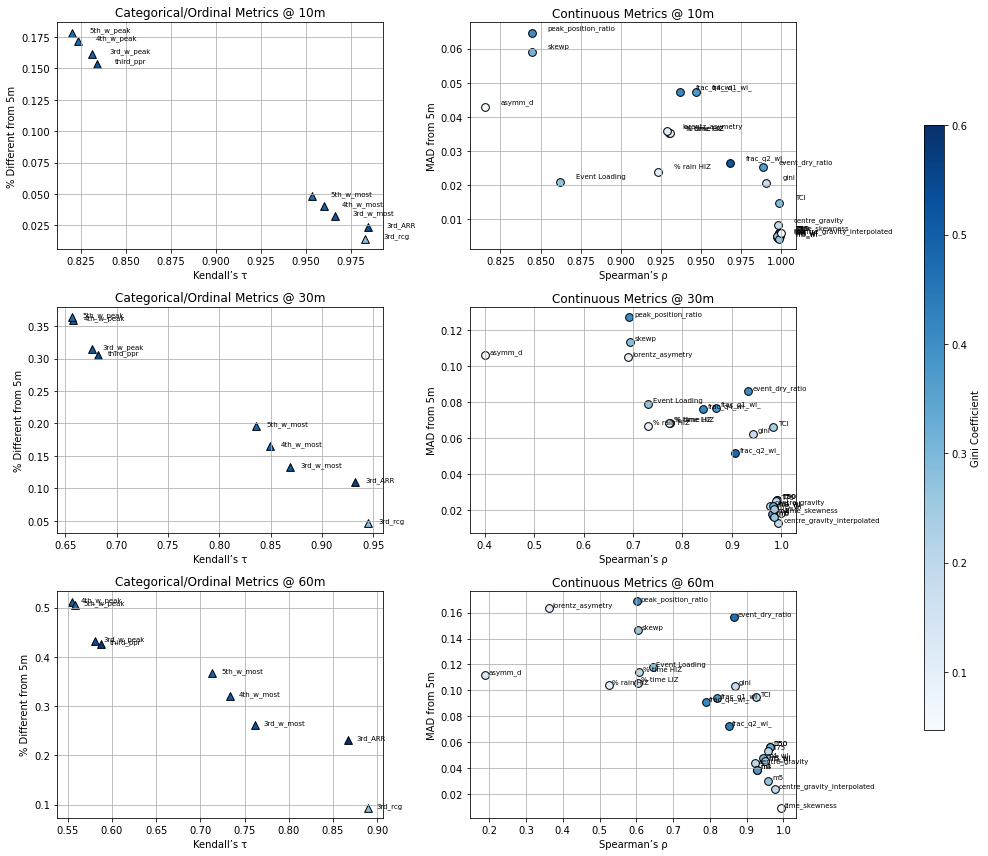

In [131]:
plot_metric_sensitivity_2d_with_gini(summary_df)

In [213]:
# plot_metric_sensitivity_3d(summary_df)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator


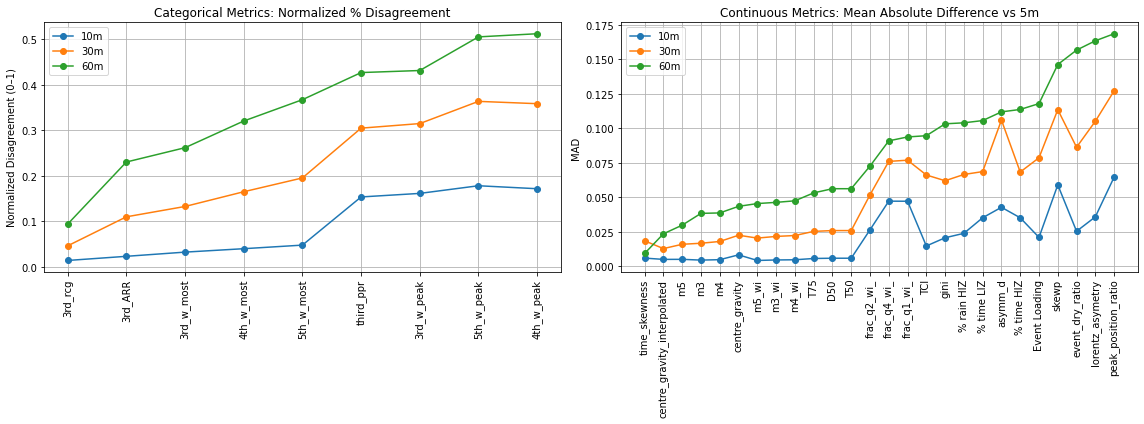

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compute_val_diff_categorical(df, categorical_metrics, resolutions):
    val_diff_results = {res: [] for res in resolutions if res != '5m'}
    for metric in categorical_metrics:
        ref = df[f"{metric}_5m"]
        for res in val_diff_results:
            col = f"{metric}_{res}"
            if col in df.columns:
                comp = df[col]
                valid = ref.notna() & comp.notna()
                x = ref[valid]
                y = comp[valid]
                if len(x) == 0:
                    val_diff = np.nan
                else:
                    observed_diff = (x != y).mean() * 100
                    n_classes = x.nunique()
                    max_diff = (1 - 1 / n_classes) * 100 if n_classes > 1 else 1
                    val_diff = observed_diff / max_diff  # normalized disagreement (0–1)
                val_diff_results[res].append(val_diff)
            else:
                val_diff_results[res].append(np.nan)
    return pd.DataFrame(val_diff_results, index=categorical_metrics)


def compute_mad_relative_to_5m(df, continuous_metrics, resolutions):
    mad_results = {res: [] for res in resolutions if res != '5m'}
    for metric in continuous_metrics:
        ref = df[f"{metric}_5m"]
        for res in mad_results:
            col = f"{metric}_{res}"
            if col in df.columns:
                comp = df[col]
                diff = np.abs(comp - ref)
                mad_results[res].append(diff.mean())
            else:
                mad_results[res].append(np.nan)
    return pd.DataFrame(mad_results, index=continuous_metrics)


# Example usage
resolutions = ['5m', '10m', '30m', '60m']

val_diff_df = compute_val_diff_categorical(transformed_minmax_scaled, categorical_metrics, resolutions)
mad_df = compute_mad_relative_to_5m(transformed_minmax_scaled, continuous_metrics, resolutions)

val_diff_df.sort_values(by='60m', inplace=True)
mad_df.sort_values(by='60m', inplace=True)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left: categorical
for res in val_diff_df.columns:
    axes[0].plot(val_diff_df.index, val_diff_df[res], marker='o', label=res)
axes[0].set_title('Categorical Metrics: Normalized % Disagreement')
axes[0].set_ylabel('Normalized Disagreement (0–1)')
axes[0].set_xticklabels(val_diff_df.index, rotation=90)
axes[0].legend()
axes[0].grid(True)

# Right: continuous
for res in mad_df.columns:
    axes[1].plot(mad_df.index, mad_df[res], marker='o', label=res)
axes[1].set_title('Continuous Metrics: Mean Absolute Difference vs 5m')
axes[1].set_ylabel('MAD')
axes[1].set_xticklabels(mad_df.index, rotation=90)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


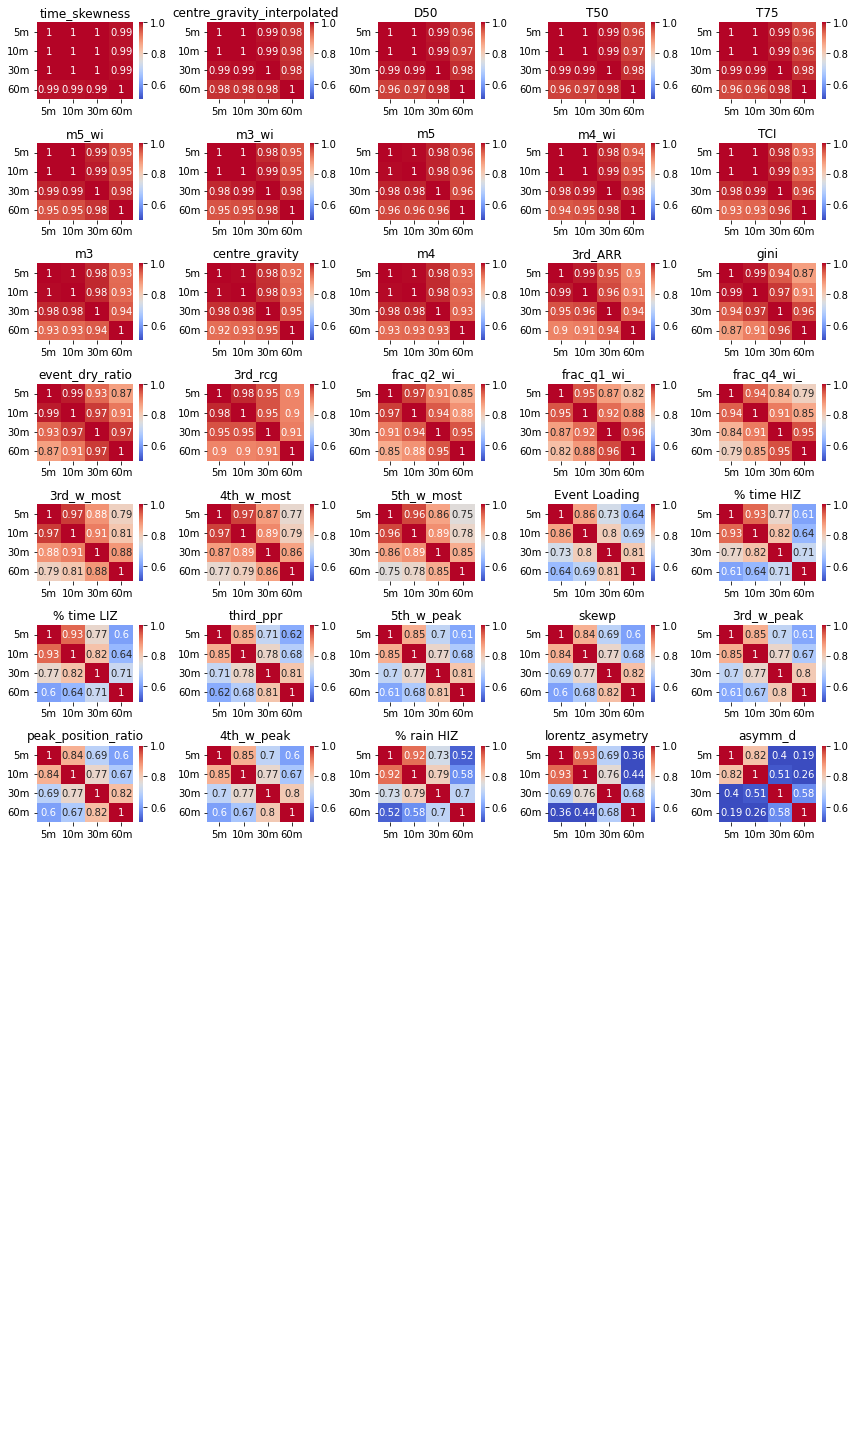

In [135]:
# Step 1: Extract unique metrics from column names
metrics = set()
for col in transformed_minmax_scaled.columns:
    metric, res = split_metric_resolution(col)
    if res is not None:
        metrics.add(metric)

# Step 2: Compute average Spearman correlation for each metric
metric_corrs = []
for metric in metrics:
    try:
        # Create a DataFrame with all resolutions of this metric
        data = pd.DataFrame({
            res: transformed_minmax_scaled[f"{metric}_{res}"] for res in resolutions
        })

        corr_matrix = data.corr(method='spearman')
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        mean_corr = upper_tri.stack().mean()  # average of upper triangle (pairwise correlations)
        metric_corrs.append((metric, mean_corr))
    except KeyError:
        continue  # Skip metric if any resolution is missing

# Step 3: Sort metrics by descending average correlation
sorted_metrics = [m for m, _ in sorted(metric_corrs, key=lambda x: -x[1])]

# Step 4: Plot heatmaps with sorted metric order
fig, axs = plt.subplots(12, 5, figsize=(12, 20))
axs = axs.flatten()

for i, metric in enumerate(sorted_metrics):
    try:
        data = pd.DataFrame({
            res: transformed_minmax_scaled[f"{metric}_{res}"] for res in resolutions
        })
        corr = data.corr(method='spearman')
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axs[i], vmin=0.5, vmax=1)
        axs[i].set_title(f"{metric}")
    except KeyError:
        axs[i].axis('off')  # In case of missing data

# Hide any extra axes
for j in range(len(sorted_metrics), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# # Example: column names like "3rd_rcg_5m", "3rd_rcg_10m", etc.
# metric_base = "3rd_w_peak"
# resolutions = ["5m", "10m", "30m", "60m"]
# df = all_events_all_res

# # Count values
# value_counts = pd.DataFrame({
#     res: df[f"{metric_base}_{res}"].value_counts(normalize=True)
#     for res in resolutions
# }).fillna(0)

# # Reindex columns to ensure order: 1, 2, 3
# value_counts = value_counts.reindex([1, 2, 3], axis=0)

# # Plot
# value_counts.T.plot(kind='bar', stacked=True, colormap='Set2')
# plt.title("Distribution of '3rd_rcg' across resolutions")
# plt.ylabel("Proportion of Events")
# plt.xlabel("Resolution")
# plt.legend(title="Third with CoM", loc='upper right')
# plt.tight_layout()
# plt.show()
